<a href="https://colab.research.google.com/github/kshs040666/MyMaster/blob/main/FasterRCNN/Inception_FRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd drive/MyDrive/Colab Notebooks/20220819
!pip install -r requirements.txt

/content/drive/MyDrive/Colab Notebooks/20220819
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import seaborn as sn
import numpy as np
import cv2
import os
import re
import time
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import layoutparser as lp
from pycocotools.coco import COCO

In [ ]:
from engine import train_one_epoch, evaluate
import utils


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.get_device_name())

Tesla P100-PCIE-16GB


In [ ]:
# %cd wood_defect_dataset_COCO_format
root = 'wood_defect_dataset_COCO_format'
train_anns_path = os.path.join(root, 'annotations', 'instances_train2017.json')
val_anns_path = os.path.join(root, 'annotations', 'instances_val2017.json')
test_anns_path = os.path.join(root, 'annotations', 'instances_test2017.json')
train_coco = COCO(train_anns_path)
val_coco = COCO(val_anns_path)
test_coco = COCO(test_anns_path)

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [ ]:
class WoodDataset(Dataset):
    def __init__(self, image_dir, coco, transforms=None, mode='train'):
        super().__init__()
        self.image_dir = image_dir
        self.coco = coco        
        self.transforms = transforms
        
        
    def __getitem__(self, index : int):
        index += 1
        image_id = index
        image_info = self.coco.imgs[index]
        anns = self.coco.loadAnns(self.coco.getAnnIds([index]))
        n = len(anns)

        image = cv2.imread(os.path.join(self.image_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        boxes=np.zeros((n, 4))
        area = np.zeros(n)
        iscrowd = np.zeros(n)
        labels = np.zeros(n, dtype = np.int64)
        image_ids = np.zeros(n)

        for i in range(n):
          boxes[i, :] = anns[i]['bbox']
          area[i] = anns[i]['area']
          iscrowd[i] = anns[i]['iscrowd']
          labels[i] = anns[i]['category_id']
          image_ids[i] = anns[i]['image_id']
        boxes_yolo = boxes.copy()
        boxes_yolo[:, 2] = boxes[:,0] + boxes[:,2]
        boxes_yolo[:, 3] = boxes[:,1] + boxes[:,3]

        check = area > 0
        area = area[check]
        boxes_yolo = boxes_yolo[check]
        labels = labels[check]
        iscrowd = iscrowd[check]
        image_ids = torch.tensor([index])

        boxes = torch.as_tensor(boxes_yolo, dtype=torch.float32)
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
        image_ids = torch.as_tensor(image_ids, dtype=torch.int64)
            
        target={}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_ids
        target['area'] = area
        target['iscrowd'] = iscrowd
            
        if self.transforms:
                sample = {
                    'image': image, 'bboxes': target['boxes'], 'labels': target['labels']
                }
                sample = self.transforms(**sample)
                image = sample['image']
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                target['boxes'] = target['boxes'].type(torch.float32)
        return  image, target
        
    def __len__(self) -> int:
        return len(self.coco.imgs)

In [ ]:
from albumentations.augmentations import VerticalFlip
from albumentations.augmentations.transforms import HorizontalFlip
from albumentations.augmentations.geometric.resize import Resize
train_aug = A.Compose([
    Resize(512, 1024), 
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_aug = A.Compose([
    Resize(512, 1024), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [ ]:
train_data = WoodDataset(os.path.join(root, 'train2017'), train_coco, transforms=train_aug)
val_data = WoodDataset(os.path.join(root, 'val2017'), val_coco, transforms=val_aug)
test_data = WoodDataset(os.path.join(root, 'test2017'), test_coco, transforms=val_aug)

In [ ]:
batch_size = 8
train_data_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)
valid_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)

test_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

In [ ]:
from torch.nn.modules.container import Sequential
class FRCNN_Googlenet(torch.nn.Module):
  def __init__(self) -> None:
      super().__init__()
      google = torchvision.models.googlenet()
      self.googlenet = Sequential(google.conv1, 
                                  google.maxpool1, 
                                  google.conv2, 
                                  google.conv3, 
                                  google.maxpool2, 
                                  google.inception3a, 
                                  google.inception3b, 
                                  google.maxpool3, 
                                  google.inception4a, 
                                  google.inception4b, 
                                  google.inception4c, 
                                  google.inception4d, 
                                  google.inception4e, 
                                  google.maxpool4, 
                                  google.inception5a, 
                                  google.inception5b
      )
      self.out_channels = 1024
  def forward(self, x):
      return self.googlenet(x)

In [ ]:
from torchvision.models import alexnet

modelname = 'Googlenet'
anchor_generator = AnchorGenerator(sizes=((32, 64, 128), ), 
                                   aspect_ratios=((0.5, 1, 2), )
                                   )
model = FasterRCNN(FRCNN_Googlenet(), 
           num_classes=9, 
           rpn_anchor_generator=anchor_generator)

params = [p for p in model.parameters() if p.requires_grad]

optimizer_type = 'SGD'
optimizer = torch.optim.SGD(params, lr=5e-5, momentum=0.8)
lr_scheduler = None

model.to(device)


In [35]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): FRCNN_Googlenet(
    (googlenet): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (2): BasicConv2d(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): BasicConv2d(
        (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (4): MaxPool2d

In [ ]:
# model.load_state_dict(torch.load(os.path.join('models', 'Alexnet_SGD_epoch_102.pth')))

<All keys matched successfully>

In [ ]:
num_epochs = 1200
total_train_loss = []
total_valid_loss = []


In [ ]:
from torch.utils.tensorboard import SummaryWriter
import datetime
logdir = os.path.join('logs', f'FasterRCNN_{modelname}_{optimizer_type}')
# event_path = '/content/drive/MyDrive/Colab Notebooks/20220819/logs/20220824-022022'
writer = SummaryWriter(logdir)


In [15]:
torch.manual_seed(2)
model.train()
t0 = time.time()
best_val_loss = 10000.0
last_update_epoch = 0
itr = 0
for epoch in range(0, num_epochs):

    train_loss = []
    valid_loss = []
    batch_loss = []
    n = 0
#################################### Train ############################################# 
    for images, targets in train_data_loader:

        images = list(image.to(device) for image in images)
        itr += 1
        n += 1
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        batch_size = len(images)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())     # Returns losses and detections
        loss_value = losses.item()
        train_loss.append(loss_value)

        optimizer.zero_grad()
        losses = losses.to(torch.float32)

        now = time.time()
        writer.add_scalar('Loss/iter_loss', loss_value, itr, now)

        losses.backward()
        optimizer.step()
        if n % 30 == 0:
          t1 = time.time()
          t = t1 - t0
          tstr = time.strftime('%H:%M:%S', time.gmtime(t))
          print(f'Epoch: [{epoch}] [{n}/{len(train_data)//batch_size}] \t loss: {np.mean(train_loss):.4f} \t Training time: {tstr}')
      

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
############################# valid #########################################           
    valid_loss = []        
    for val_images, val_targets in valid_data_loader:
        val_images = list(val_image.to(device) for val_image in val_images)
        val_targets = [{k: v.to(device) for k, v in t.items()} for t in val_targets]

        val_loss_dict = model(val_images, val_targets)
        val_losses = sum(loss for loss in val_loss_dict.values())
        val_loss_value = val_losses.item()
        valid_loss.append(val_loss_value)
        # val_loss_hist.send(val_loss_value)

############################ log ###########################################
    epoch_train_loss = np.mean(train_loss)
    epoch_valid_loss = np.mean(valid_loss)
    now = time.time()
    writer.add_scalar('Loss/train', epoch_train_loss, epoch, now)
    writer.add_scalar('Loss/val', epoch_valid_loss, epoch, now)

############################ save ##########################################   
    if epoch_valid_loss < best_val_loss:
        best_val_loss = epoch_valid_loss
        best_model = model
        print(f'Model Updated! \t Validation Loss: {best_val_loss:.4f}')

        save_name = f'{modelname}_{optimizer_type}_epoch_{epoch}.pth'
        last_save_name = f'{modelname}_{optimizer_type}_epoch_{last_update_epoch}.pth'
        torch.save(best_model.state_dict(), os.path.join('models', save_name))

        if os.path.exists(os.path.join('models', last_save_name)):
          os.remove(os.path.join('models', last_save_name))
        last_update_epoch = epoch   
#############################################################################
writer.close()

Epoch: [0] [30/361] 	 loss: 2.7047 	 Training time: 00:00:27
Epoch: [0] [60/361] 	 loss: 2.3789 	 Training time: 00:00:54
Epoch: [0] [90/361] 	 loss: 2.0392 	 Training time: 00:01:20
Epoch: [0] [120/361] 	 loss: 1.7673 	 Training time: 00:01:47
Epoch: [0] [150/361] 	 loss: 1.5722 	 Training time: 00:02:11
Epoch: [0] [180/361] 	 loss: 1.4302 	 Training time: 00:02:37
Epoch: [0] [210/361] 	 loss: 1.3244 	 Training time: 00:03:02
Epoch: [0] [240/361] 	 loss: 1.2412 	 Training time: 00:03:27
Epoch: [0] [270/361] 	 loss: 1.1726 	 Training time: 00:03:53
Epoch: [0] [300/361] 	 loss: 1.1157 	 Training time: 00:04:18
Epoch: [0] [330/361] 	 loss: 1.0672 	 Training time: 00:04:43
Epoch: [0] [360/361] 	 loss: 1.0256 	 Training time: 00:05:09
Model Updated! 	 Validation Loss: 0.5534
Epoch: [1] [30/361] 	 loss: 0.5477 	 Training time: 00:06:17
Epoch: [1] [60/361] 	 loss: 0.5384 	 Training time: 00:06:44
Epoch: [1] [90/361] 	 loss: 0.5278 	 Training time: 00:07:10
Epoch: [1] [120/361] 	 loss: 0.5196

KeyboardInterrupt: ignored

In [16]:
loss_dict

{'loss_classifier': tensor(0.0723, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0450, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0373, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0276, device='cuda:0', grad_fn=<DivBackward0>)}

In [17]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import nms, box_iou


In [38]:
idx = 8
model.eval().to(device)
rec = model(test_data[idx][0].unsqueeze(0).to(device))
rec = rec[0]
rec

{'boxes': tensor([[4.5838e+02, 5.3053e-01, 5.7847e+02, 8.4110e+01],
         [4.6960e+02, 4.4468e+00, 5.8169e+02, 6.0477e+01],
         [4.8023e+02, 1.7460e+01, 5.5053e+02, 5.0472e+01],
         [4.8034e+02, 1.7038e+01, 5.4984e+02, 5.0369e+01],
         [4.8781e+02, 2.8190e+01, 5.4717e+02, 6.1941e+01],
         [4.8776e+02, 2.8386e+01, 5.4681e+02, 6.1554e+01],
         [5.0731e+02, 2.7166e+01, 5.6663e+02, 5.9656e+01],
         [5.0420e+02, 1.3516e+01, 5.6432e+02, 4.6561e+01],
         [5.0465e+02, 1.3287e+01, 5.6380e+02, 4.6604e+01],
         [5.0745e+02, 2.7214e+01, 5.6612e+02, 5.9259e+01],
         [5.1794e+02, 1.9022e+01, 5.5782e+02, 5.3126e+01],
         [4.2019e+02, 5.4204e+00, 5.9626e+02, 7.5255e+01],
         [5.1456e+02, 0.0000e+00, 5.3506e+02, 8.0622e+01],
         [5.0129e+02, 3.2375e+01, 5.3451e+02, 6.0951e+01],
         [5.1822e+02, 1.8933e+01, 5.5732e+02, 5.2962e+01],
         [5.0498e+02, 1.1858e+00, 5.2771e+02, 6.5462e+01],
         [5.0136e+02, 3.2566e+01, 5.3418e+02, 6

In [39]:
nms_idx = torchvision.ops.nms(rec['boxes'], rec['scores'], 0.01)
bbox_pred = rec['boxes'][nms_idx].cpu()
labels_pred = rec['labels'][nms_idx].cpu()

In [40]:
labels_pred

tensor([2])

In [41]:
bbox_gt = test_data[idx][1]['boxes']
labels_gt = test_data[idx][1]['labels']
labels_gt

tensor([5, 2])

Text(0.5, 1.0, 'Gt')

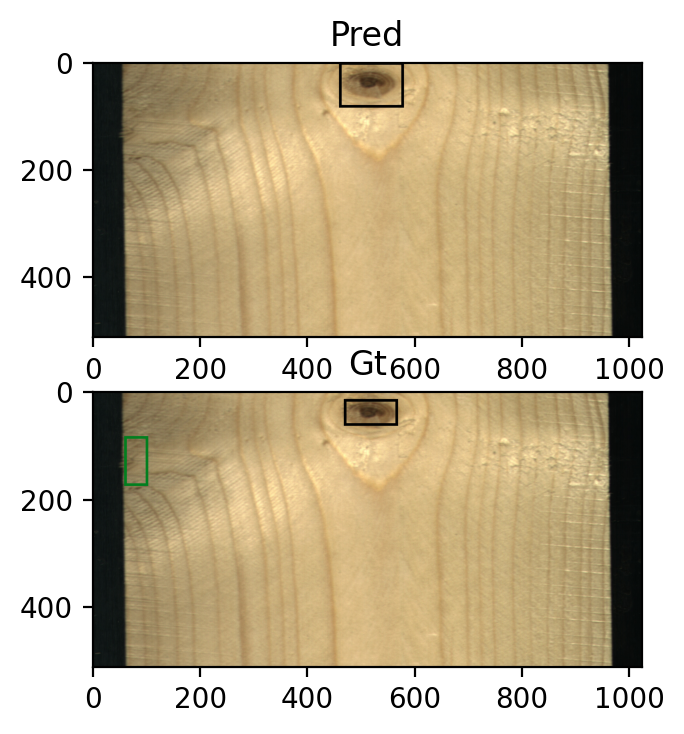

In [42]:
image = torch.as_tensor(test_data[idx][0], dtype=torch.uint8)
image_draw = draw_bounding_boxes(image, bbox_pred, width=5)
image_draw_gt = draw_bounding_boxes(image, bbox_gt, width=5)
image_draw_pil = to_pil_image(image_draw)
image_draw_pil_gt = to_pil_image(image_draw_gt)
plt.figure(dpi=200)
plt.subplot(211)
plt.imshow(np.asarray(image_draw_pil))
plt.title('Pred')
plt.subplot(212)
plt.imshow(np.asarray(image_draw_pil_gt))
plt.title('Gt')

In [48]:
cm = box_iou(bbox_gt, bbox_pred)
TP = (cm >= 0.4).sum()
FP = len(bbox_pred) - TP
FN = len(bbox_gt) - TP
acc = TP/(TP+FP+1e-6)
acc

tensor(1.0000)

In [47]:
label_order = cm.argmax(dim=0)

gt2 = labels_gt[label_order]
cls_cm = np.zeros((8,8))
for i in range(len(gt2)):
  cls_cm[gt2[i]-1, labels_pred[i]-1] += 1

cls_cm

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [49]:
box_precisions = []
box_recalls = []
eps = 1e-6
cls_cm = np.zeros((8, 8))

for idx in range(len(test_data)):
  image = test_data[idx][0]
  target = test_data[idx][1]
  rec = model(image.unsqueeze(0).to(device))
  rec = rec[0]

  nms_idx = nms(rec['boxes'], rec['scores'], 0.01)
  bbox_pred = rec['boxes'][nms_idx].cpu()
  labels_pred = rec['labels'][nms_idx].cpu()

  bbox_gt = target['boxes']
  labels_gt = target['labels']

  cm = box_iou(bbox_gt, bbox_pred)
  box_TP = (cm>0.4).sum()
  box_FP = len(bbox_pred) - box_TP
  box_FN = len(bbox_gt) - box_TP

  box_precision = box_TP/(box_TP + box_FP + eps)
  box_recall = box_TP/(box_TP + box_FN + eps)

  box_precisions.append(box_precision)
  box_recalls.append(box_recall)

  gt2 = labels_gt[cm.argmax(dim=0)]
  for i in range(len(gt2)):
    cls_cm[gt2[i]-1, labels_pred[i]-1] += 1

In [26]:
# with open(os.path.join('Classification_matrix', f'{modelname}_FRCNN.npy'), 'wb') as f:
#   np.save(f, cls_cm)

In [34]:
cls_precision = np.zeros(8)
cls_recall = np.zeros(8)
for i in range(8):
  cls_precision[i] = cls_cm[i,i]/(cls_cm[:,i].sum()+eps)
  cls_recall[i] = cls_cm[i,i]/(cls_cm[i,:].sum()+eps)
cls_recall.mean()

0.12499999972160357

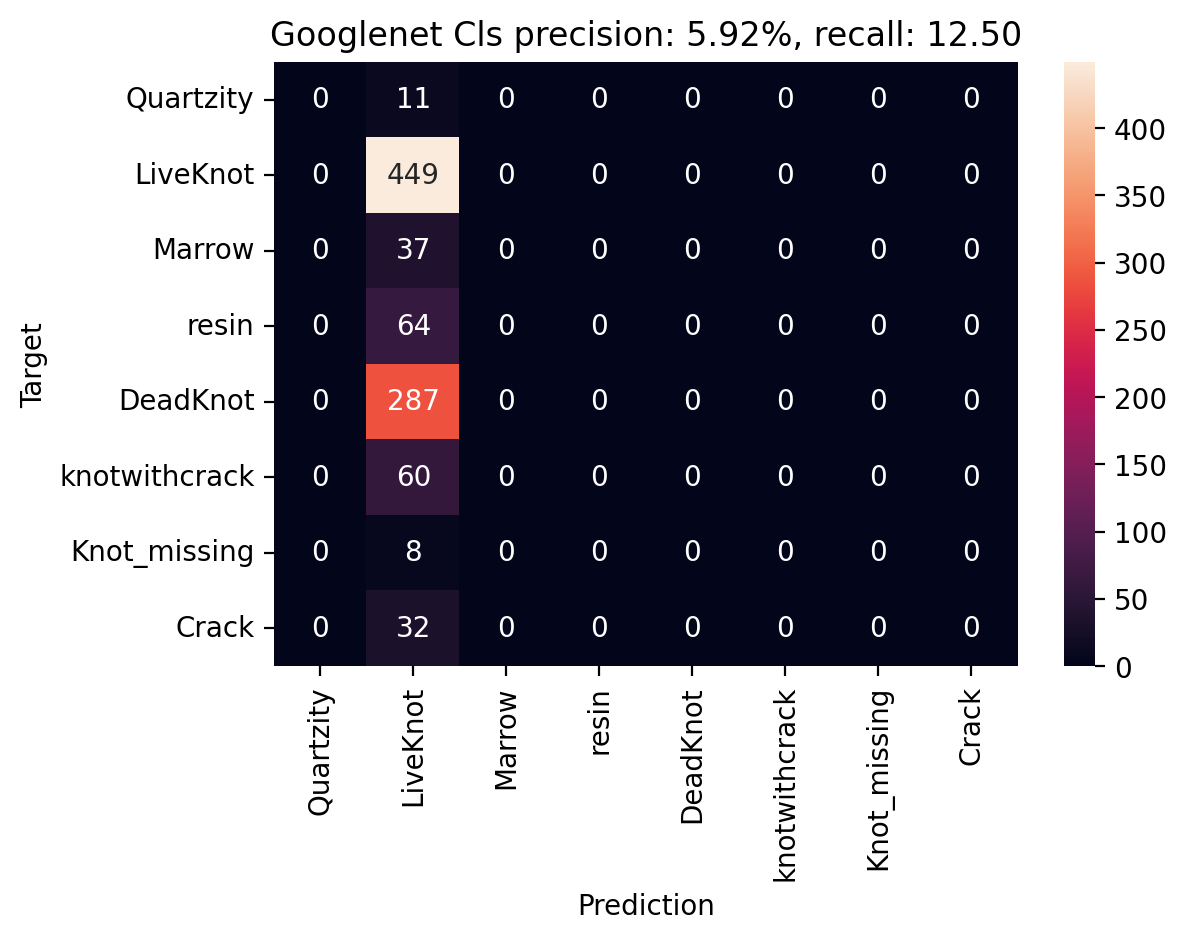

In [28]:
classes = ['Quartzity', 'LiveKnot', 'Marrow', 'resin', 'DeadKnot', 'knotwithcrack', 'Knot_missing', 'Crack']
df_cls_cm = pd.DataFrame((cls_cm), 
                         index = [i for i in classes], 
                        columns = [i for i in classes], dtype='int')
plt.figure(dpi=200)
sn.heatmap(df_cls_cm, annot=True, fmt='d') 
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title(f'{modelname} Cls precision: {cls_precision.mean()*100:.2f}%, recall: {cls_recall.mean()*100:.2f}')
# plt.savefig(os.path.join('Classification_matrix', f'{modelname}_FRCNN.png'))
           

In [30]:
df = pd.DataFrame(data=[box_precisions, box_recalls], dtype='double').transpose()
df.columns = ['box_precision', 'box_recall']
df.head(10)

,box_precision,box_recall
0,0.000000,0.000000
1,0.999999,0.500000
2,0.000000,0.000000
3,0.999999,0.999999
4,0.500000,0.333333
5,0.600000,0.750000
6,1.000000,1.000000
7,0.000000,0.000000
8,0.000000,0.000000
9,0.000000,0.000000


In [32]:
df['box_precision'].mean()

0.46039855213954506

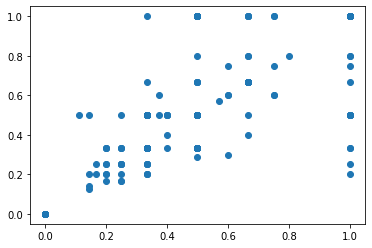

In [37]:
plt.plot(df['box_precision'], df['box_recall'], 'o')